In [5]:
import sys
sys.path.append('..')

import os
from glob import glob
from collections import defaultdict
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
vertices = defaultdict(list)
faces = defaultdict(list)
with h5py.File("../data/shapenet/data.h5") as file:
    for cat in tqdm(file.keys(), total=len(file.keys())):
        for obj in file[cat].keys():
            data = file[cat][obj]
            vertices[cat].append(data['node'].shape[0])
            faces[cat].append(data['hyperedge'].shape[1])
            assert data['node'].shape[0] == data['hyperedge'].shape[0]

100%|██████████| 55/55 [05:22<00:00,  5.87s/it]


In [3]:
tax = json.load(open("../data/shapenet/raw/ShapeNetCore.v2/taxonomy.json", 'r'))

In [4]:
def find_cat(cat):
    for item in tax:
        if item['synsetId'] == cat:
            return item['name']
    raise IndexError

In [29]:
df = pd.DataFrame(columns=["category", "# instances (before)", " instances (after)"])
records = []
for key in vertices.keys():
    data = vertices[key]
    cat = find_cat(key)
    before = len(os.listdir(os.path.join("../data/shapenet/raw/ShapeNetCore.v2", key)))
    after  = len(data)
    records.append({
        "category": cat,
        "before": before,
        "after": after
    })
df = pd.DataFrame.from_records(records)

In [20]:
import json
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [5]:
data = json.load(open("../data/shapenet/meta.json", "r"))

(array([ 52., 351., 492., 412., 379., 359., 281., 259., 197., 189., 177.,
        173., 193., 152., 196., 138., 142., 114., 116., 106., 110.,  82.,
         90.,  66.,  81., 104.,  91.,  63.,  57.,  51.,  59.,  53.,  61.,
         53.,  50.,  61.,  60.,  39.,  29.,  41.,  35.,  28.,  41.,  32.,
         32.,  26.,  31.,  30.,  24.,  35.]),
 array([  8.  ,  23.84,  39.68,  55.52,  71.36,  87.2 , 103.04, 118.88,
        134.72, 150.56, 166.4 , 182.24, 198.08, 213.92, 229.76, 245.6 ,
        261.44, 277.28, 293.12, 308.96, 324.8 , 340.64, 356.48, 372.32,
        388.16, 404.  , 419.84, 435.68, 451.52, 467.36, 483.2 , 499.04,
        514.88, 530.72, 546.56, 562.4 , 578.24, 594.08, 609.92, 625.76,
        641.6 , 657.44, 673.28, 689.12, 704.96, 720.8 , 736.64, 752.48,
        768.32, 784.16, 800.  ]),
 <BarContainer object of 50 artists>)

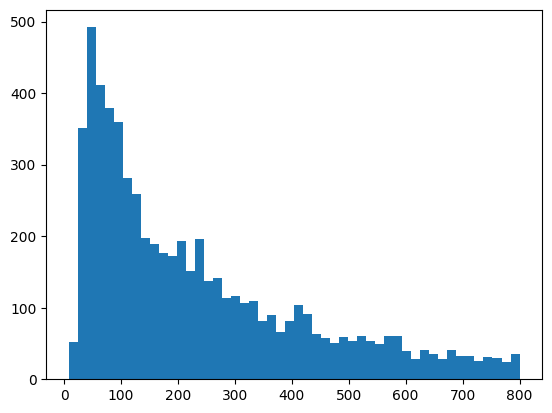

In [10]:
plt.hist(data['n_nodes'], bins=50)

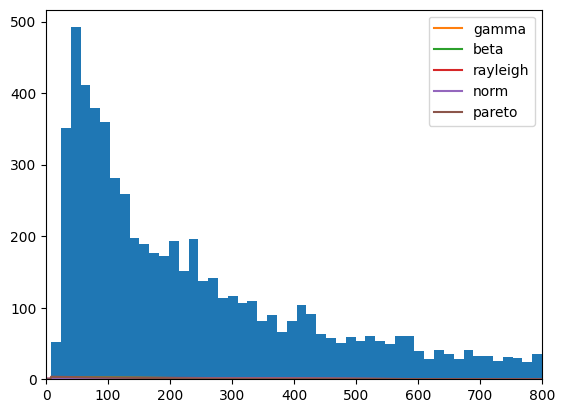

In [19]:
dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']
size = 800
x = np.arange(size)
plt.hist(data['n_nodes'], bins=50)

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(data['n_nodes'])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=scale) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0, size)
plt.legend(loc='upper right')
plt.show()

In [35]:
from scipy.stats import nbinom, poisson, geom
x = data['n_nodes']
x = pd.Series(x)
mean = x.mean()
var = x.var()
likelihoods = {}  # we'll use it later

p = mean / var
r = p * mean / (1-p)
likelihoods['nbinom'] = x.map(lambda val: nbinom.logpmf(val, r, p)).sum()

# from Wikipedia,
# mean = variance = lambda. Nothing to solve here
lambda_ = mean
likelihoods['poisson'] = x.map(lambda val: poisson.logpmf(val, lambda_)).sum()

# mean = 1 / p  # this form fits the scipy definition
p = 1 / mean
likelihoods['geometric'] = x.map(lambda val: geom.logpmf(val, p)).sum()

best_fit = max(likelihoods, key=lambda x: likelihoods[x])
print("Best fit:", best_fit)
print("Likelihood:", likelihoods[best_fit])

Best fit: nbinom
Likelihood: -39074.460039418846


In [67]:
np.histogram(data['n_nodes'], bins=np.arange(1, 801), density=True)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00016412, 0.        , 0.        ,
        0.00016412, 0.        , 0.        , 0.        , 0.        ,
        0.0036107 , 0.        , 0.00032825, 0.        , 0.00344658,
        0.        , 0.00049237, 0.00032825, 0.00475956, 0.00016412,
        0.00082061, 0.        , 0.00377482, 0.00032825, 0.00131298,
        0.        , 0.02150008, 0.00098474, 0.00344658, 0.00114886,
        0.01148859, 0.00262596, 0.0036107 , 0.00164123, 0.01854587,
        0.00279009, 0.00279009, 0.00164123, 0.00837026, 0.00180535,
        0.0036107 , 0.00279009, 0.0144428 , 0.00262596, 0.00410307,
        0.00196947, 0.00689316, 0.00262596, 0.0036107 , 0.0021336 ,
        0.01280158, 0.00131298, 0.00410307, 0.00164123, 0.00656491,
        0.00246184, 0.0036107 , 0.00180535, 0.009355  , 0.00279009,
        0.00377482, 0.00262596, 0.00607254, 0.00164123, 0.00475956,
        0.00229772, 0.01411456, 0.0036107 , 0.00

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,  22.,   0.,   2.,
          0.,  21.,   0.,   3.,   2.,  29.,   1.,   5.,   0.,  23.,   2.,
          8.,   0., 131.,   6.,  21.,   7.,  70.,  16.,  22.,  10., 113.,
         17.,  17.,  10.,  51.,  11.,  22.,  17.,  88.,  16.,  25.,  12.,
         42.,  16.,  22.,  13.,  78.,   8.,  25.,  10.,  40.,  15.,  22.,
         11.,  57.,  17.,  23.,  16.,  37.,  10.,  29.,  14.,  86.,  22.,
         19.,  10.,  33.,  10.,  18.,  14.,  56.,  10.,  22.,   9.,  31.,
         15.,  12.,  12.,  54.,   7.,  22.,  20.,  20.,  17.,  22.,   3.,
         74.,   7.,  19.,   9.,  34.,  24.,  19.,   8.,  53.,  13.,  19.,
          8.,  35.,   8.,  16.,  13.,  31.,  16.,  16.,   9.,  21.,   9.,
         14.,  13.,  31.,  10.,  16.,  12.,  24.,  15.,  17.,   3.,  35.,
          6.,  20.,  10.,  22.,   9.,  16.,   4.,  20.,  11.,  11.,   8.,
         16.,   6.,   8.,  16.,  33.,   9.,  12.,   6.,  20.,   8.,   9.,
          6.,  20.,  10.,  12.,   6., 

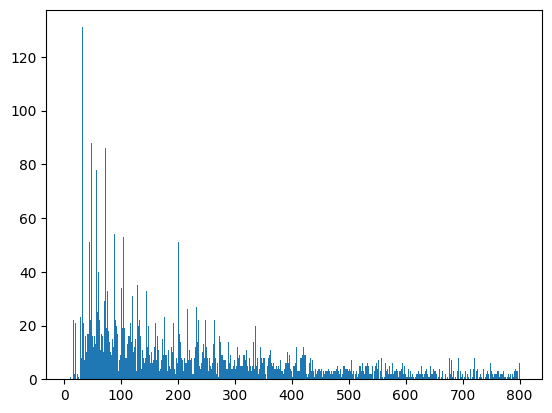

In [62]:
# p = mean / var
# r = p * mean / (1-p)
# p = 1 / mean
# lambda_ = mean

plt.hist(data['n_nodes'], bins=792)
# x = np.arange(1, 800)
# y = poisson.pmf(x, p)
# plt.plot(x, y)